# **Hello there!**

This is a Jupyter notebook for running Molecular Dynamics (MD) simulations of Alkanes using the OpenMM engine

Adapted by Professor Paul Robustelli from Pablo Arantes' "Making it Rain" and completed for Dartmouth CHEM 101.6/96.6 by J.W. Dell '22

---
---
# **Setting up the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    OpenMM (https://openmm.org/)
3.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    AmberTools (https://ambermd.org/AmberTools.php)

In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes; please, drink a coffee and wait. ;-)
# install dependencies
!pip -q install py3Dmol 2>&1 1>/dev/null
!pip install --upgrade MDAnalysis 2>&1 1>/dev/null
!pip install biopandas 2>&1 1>/dev/null
# install conda
!wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh 
!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
!rm Miniconda3-latest-Linux-x86_64.sh
!conda install -y -q -c conda-forge openmm=7.6 python=3.7 pdbfixer 2>&1 1>/dev/null
!conda install -c conda-forge ambertools --yes 2>&1 1>/dev/null
!conda install -c ambermd pytraj  --yes 2>&1 1>/dev/null
#load dependencies
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request  
import numpy as np
import MDAnalysis as mda
import py3Dmol
from __future__ import print_function
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats
#%matplotlib inline
#set_matplotlib_formats('png')
#plt.figure(figsize=(5,7))

## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest that you:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [ ]:
#@title ### **Import Google Drive**
#@markdown Click the "Run" button to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jan  9 21:01:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from simtk import unit
from openmm import app

#Let's load in our Butane Molecule and Force Field from our Google Drive
PDB_file_name = 'butane.pdb'
forcefield_file_name = 'butane.gaff2.xml' 
Google_Drive_Path = '/content/drive/MyDrive/22W/chem96' #@param {type:"string"}
workDir = Google_Drive_Path
initial_pdb = os.path.join(workDir, str(PDB_file_name))
force_field = os.path.join(workDir,str(forcefield_file_name))
print(initial_pdb)
print(force_field )

pdb = mm.app.PDBFile(initial_pdb)
forcefield = mm.app.ForceField(force_field)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/content/drive/MyDrive/22W/chem96/butane.pdb
/content/drive/MyDrive/22W/chem96/butane.gaff2.xml


In [7]:
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127868 kJ/mol
Potential energy after minimization is 5.295784483017471 kJ/mol


In [8]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,27.978823508990786,165.5813844072982
200,31.47608839865955,326.55975557197144
300,36.76526503447228,237.68277662731023
400,43.007175507559225,291.4303088321928
500,41.30621160161385,289.1661583088558
600,32.78654235680148,476.3896789979815
700,31.027831954807603,359.89785435697524
800,44.40391444822145,151.16128102846733
900,26.19086347375022,279.57018603580826
1000,42.293428618603144,366.73817265539185
1100,33.22019873842899,407.68141276779596
1200,47.5405181151517,448.30228549367524
1300,55.317169476796536,438.7011494276667
1400,39.27334855186761,367.8436315402859
1500,44.011513961567104,404.0567953852824
1600,49.34287593990956,499.25859600186294
1700,59.13225881929458,455.21686469241195
1800,49.265915786816045,245.73561201855787
1900,37.51952123330787,485.02223628382865
2000,48.298833975737956,239.37885363494325
2100,46.98548212430103,283.61794423281964
2200,55.35580112825775,338.1699093915438
2300,34.367101

In [10]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# Output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('butane_sim.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
10250000,20500.000003258898,26.52413317644528,408.1114450078172,0
10500000,21000.00000336076,38.74205150329581,251.77339349962807,1.22e+04
10750000,21500.000003462625,32.981524608305925,256.5960179315952,1.22e+04
11000000,22000.000003564488,36.16892943926808,346.56828432179196,1.22e+04
11250000,22500.00000366635,35.190812065280106,339.2153747766751,1.23e+04
11500000,23000.000003768215,35.25756317407367,342.67397902789406,1.23e+04
11750000,23500.00000387008,43.09234628868697,292.5973833250168,1.23e+04
12000000,24000.00000397194,38.068208523060434,223.40640291753544,1.24e+04
12250000,24500.000004073805,42.77099261387904,366.4430793713178,1.24e+04
12500000,25000.00000417567,32.98841603185501,322.9832030048578,1.24e+04
12750000,25500.000004277532,48.191398931859105,261.3830521987374,1.24e+04
13000000,26000.000004379395,35.043348133632534,276.54465321383594,1.24e+04
13250000,26500.00000

In [11]:
!pip install nglview 2>&1 1>/dev/null
!conda install -c conda-forge mdtraj  --yes 2>&1 1>/dev/null

In [12]:
import mdtraj as md
traj = md.load('butane_sim.dcd', top=initial_pdb)


In [13]:
import ipywidgets
from ipywidgets import interact, fixed
import warnings
warnings.filterwarnings('ignore')
from google.colab import output
output.enable_custom_widget_manager()

import nglview as ngl

visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(max_frame=99999)

In [14]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


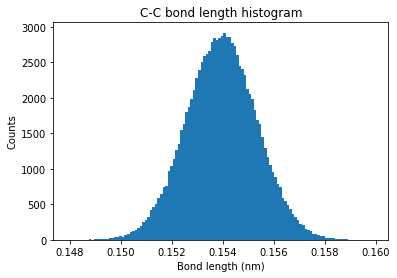

In [15]:
bond_indices = [4, 7] # atoms to define the bond length
bond_length = md.compute_distances(traj, [bond_indices])

bondcounts, binedges, otherstuff = plt.hist(bond_length, bins=120)
plt.title('C-C bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

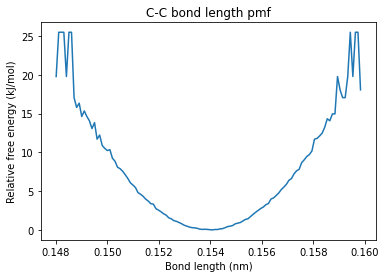

In [16]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
bondcounts[bondcounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(bondcounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-C bond length pmf')
plt.show()

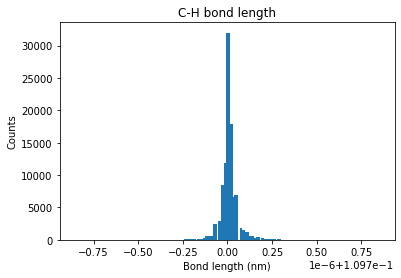

In [17]:
bond_indices = [4, 5] # many possibilities!
bondlength = md.compute_distances(traj, [bond_indices])

lengthcounts, binedges, otherstuff = plt.hist(bondlength, bins=100)
plt.title('C-H bond length')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

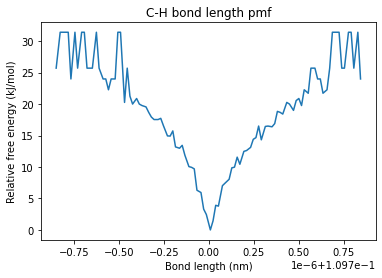

In [18]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
lengthcounts[lengthcounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(lengthcounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-H bond length pmf')
plt.show()

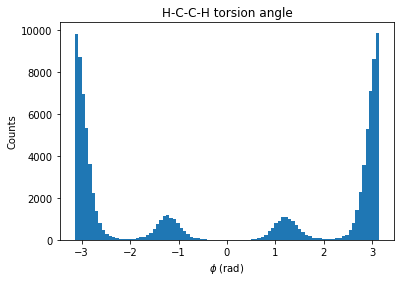

In [19]:
phi_indices = [0, 4, 7, 10] # atoms to define the torsion angle
phi = md.compute_dihedrals(traj, [phi_indices])

phicounts, binedges, otherstuff = plt.hist(phi, bins=90) # create a histogram with 90 bins
plt.title('H-C-C-H torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

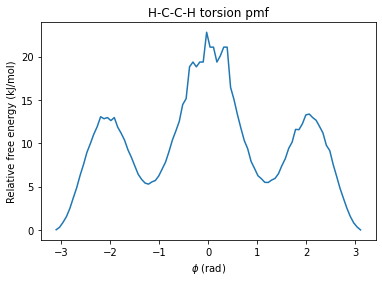

In [20]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('H-C-C-H torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

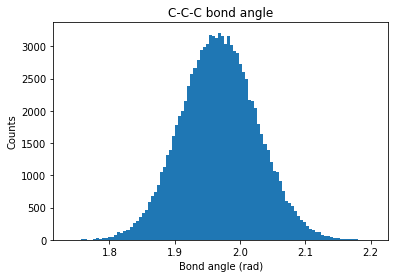

In [21]:
angle_indices = [0, 4, 7] # or could do [4, 7, 10]
bondangle = md.compute_angles(traj, [angle_indices])

anglecounts, binedges, otherstuff = plt.hist(bondangle, bins=100)
plt.title('C-C-C bond angle')
plt.xlabel('Bond angle (rad)')
plt.ylabel('Counts')
plt.show()

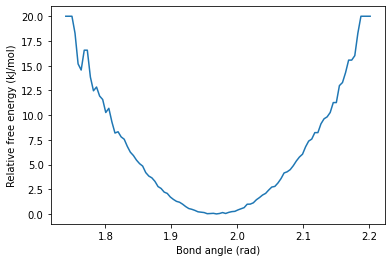

In [22]:
anglecounts[anglecounts==0] = 0.1
pmf = -kB*Temp*np.log(anglecounts)
pmf = pmf - np.min(pmf)

bincenters = (binedges[1:] + binedges[:-1])/2


plt.plot(bincenters, pmf)
plt.xlabel('Bond angle (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()